Abstand Szintillator mitt 208mm vv

Na22cal mu1 639.03 sigma1 15.72 mu2 1663.50 sigma 25.21

In [227]:
import uncertainties.unumpy as unp
import uncertainties as u
from uncertainties.umath import log


from uncertainties import ufloat
import numpy as np
import pandas as pd
import scipy as sp
import kafe2
import matplotlib.pyplot as plt
import os
import glob
import struct
import sympy

from pathlib import Path
from tools import *



In [228]:

directory =  Path().resolve()/Path("data")

file_list = [x for x in sorted(glob.glob(os.path.join(directory, '*.txt')), key=os.path.getmtime, reverse=True) if ("Peaks" in x)]
compton_files = [x for x in sorted(glob.glob(os.path.join(directory, '*.dat')), key=os.path.getmtime, reverse=True) if "target" in x]

all_files = sorted(glob.glob(os.path.join(directory, '*.dat')), key=os.path.getmtime, reverse=True)
print(compton_files)

['C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target85.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target70.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target55.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target40.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target25.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\target85.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\target70.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\target 55.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\target40.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\target25.dat']


In [229]:
# for file in all_files:
#     title = (file.split("\\"))[-1].split(".")[0]
#     if len(title)>6:
#         dxList1,tList1,nevent1= dat_extract(file)
#         plt.title(title)
#         plot_hist(dxList1,nevent1)
#         plt.show()

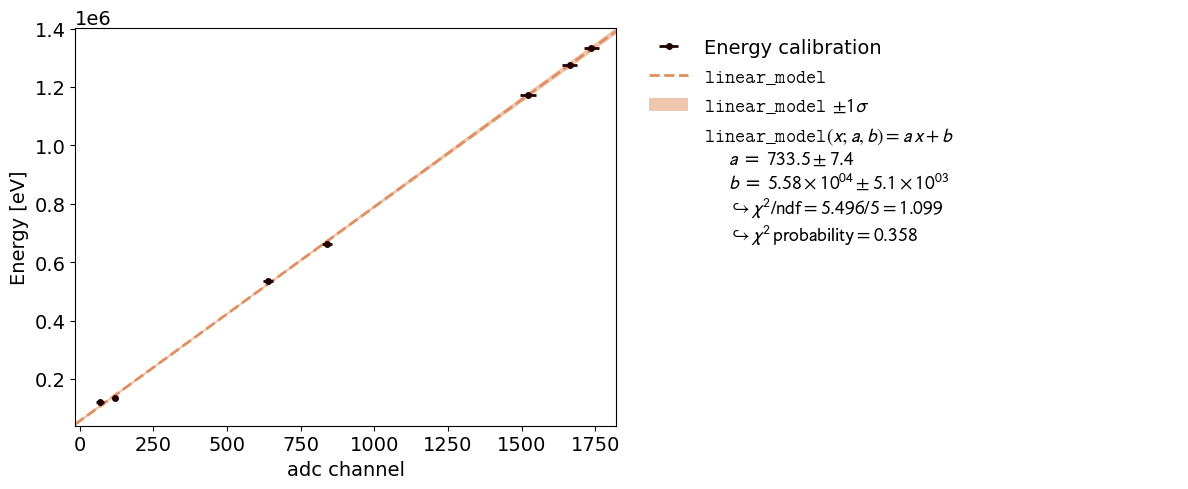

In [230]:
### Energy calibration ###

photo_channel=np.array([[640.4566927820908, 17.0401414090759, 2.834-1.275-2*510998*1e-6], [ 1663.4977923728798, 25.21176031341638 , 1.275], # Na22
                        [839.2925784848783, 17.06645531075148 , 0.662], #Cs137
                        [1520.768861718434, 27.723866249761517, 2.505 - 1.332], [1736.0718592449252, 25.399024362484912 , 1.332],  #Co60
                        [68.47946799509003, 12.832700250520432, 0.136-0.0144], [118.28899175517358, 7.775908633336143, 0.136]]) #Co57

data = kafe2.XYContainer(photo_channel[:,0],photo_channel[:,2]*1e6)
data.label = 'Energy calibration'
data.add_error('x', photo_channel[:,1])

fit = kafe2.Fit(data)
fit.do_fit()
pl = kafe2.Plot(fit)
pl.x_label = 'adc channel'
pl.y_label = 'Energy [eV]' 
#pl.x_range = (0.0014, 0.0019)

pl.plot()
plt.show()

def convertChannel(channel,error=False):
    """
    converts the channel number into the corresponding Energy in eV
    Args:
        channel: int channel of the adc

    Returns:
        float: Energy value
    """
    global fit
    if error:
        return (u.ufloat(fit.parameter_values[0], fit.parameter_errors[0])*channel+u.ufloat(fit.parameter_values[1], fit.parameter_errors[1]))*1e-6
    return (fit.parameter_values[0]*channel+fit.parameter_values[1])*1e-6


gamma flux is $\phi_{det}=A_\gamma\frac{1}{4 \pi l^2}$ with $A_\gamma=A_0 e^{-ln(2) \frac{t_{passed}}{t_{1/2}}}$

$R_\gamma=\phi_{det} \pi r^2$

$\epsilon = \frac{4N l^2}{t_{meas} A_0   r^2}e^{ln(2) \frac{t_{passed}}{t_{1/2}}}$ 
efficiency

In [ ]:


# dxList1,tList1,nevent1= dat_extract(directory/file)
# n1, bins, patches1 = plt.hist(dxList1, nBins, range=(0,nBins*binSize))

# bin_centers = bins[:-1] + binSize/2

# x1,y1=gauss_fit(bin_centers,n1,1600,1800,0)
# x,y,z=gauss_fit( bin_centers,n1,1400,1600,5)

# peak1=integrate(bin_centers,n1,x1,y1)
# peak2=integrate(bin_centers,n1,x,y,z)

# plt.show()
from uncertainties.core import UFloat
import copy
from tools import *
files=[ 
    #[Path("Co57.txt"), [[20,80,0], [100,200,0]], [300, 300, 0.744, 4]], 
       [Path("Cs137RP477.txt"), [[750,1000,0,0.944]], [300, 2.58e5,  30.2, 23/365]],
       [Path("Na22AC9255.txt"), [[500,700,10,1.8],[1500,1700,0,1]], [300, 4.28e3, 2.6, 23/365]], 
       [Path("Co60Ao2211.txt"), [[1400,1700,10,1],[1700,1900,0,1]] , [600, 4.01e4, 5.27, 23/365]]]
file=Path("Co60Ao2211.dat")
binSize=2
nBins=1000

def efficiency(Ni, t, A_0,t_2, t_sample,uncertainty=False):
    N=copy.deepcopy(Ni)
    if not isinstance(N, UFloat):
        N=u.ufloat(N,0)
    l=0.208
    r=0.0255
    if uncertainty:
        return (4*N.s*l**2)*np.exp(np.log(2)*t_sample/t_2)/(t*A_0*r**2)
    return (4*N.n*l**2)*np.exp(np.log(2)*t_sample/t_2)/(t*A_0*r**2)


eff_pairs=[]
eff_uncertainty= []
for file, lists, dat in files:
    bin_centers,n1 = getfromtxt(directory/file)

    plt.fill_between(bin_centers, n1,label="spektrum")
    try:
        for list in lists:
            activity = dat[1]*list[3]

            x,y,z=gauss_fit(bin_centers,n1,list[0],list[1],list[2])
            y=np.abs(y)
            peak=integrate(bin_centers,n1,x,y,z)
            print("Efficiency for ",convertChannel(x),"MeV:",efficiency(peak, dat[0], activity, dat[2], dat[3]))
            eff_pairs.append([convertChannel(x),efficiency(peak, dat[0], activity, dat[2], dat[3]), (str(file).split(".") )[0]])
            eff_uncertainty.append([convertChannel(y)/convertChannel(np.sqrt(peak)), efficiency(u.ufloat(peak,0), dat[0], activity, dat[2], dat[3],True)])

    except Exception as  e:
        print(e)
    plt.title(str(file))
    plt.xlim(right=list[1]+50)
    plt.legend()
    plt.show();
for pair in eff_pairs:
    plt.plot(pair[0],pair[1],"x",label=pair[2])
plt.title("detector efficiency at different energies")
plt.xlabel("Energy [MeV]")
plt.ylabel("efficiency")
plt.legend()
plt.grid(1)
plt.show()

[0.20731306 0.63736265 0.89590665 1.12531532]


c:\Users\jonah\anaconda3\envs\pua\Lib\site-packages\kafe2\fit\util\__init__.py:83: RuntimeWarning: divide by zero encountered in log
  return 2.0 * np.sum(np.log(pointwise_error))
c:\Users\jonah\anaconda3\envs\pua\Lib\site-packages\kafe2\fit\_base\cost.py:133: RuntimeWarning: invalid value encountered in scalar add
  return self._cost_function_handle(*args) + additional_cost
c:\Users\jonah\anaconda3\envs\pua\Lib\site-packages\kafe2\fit\_base\cost.py:335: UserWarning: Setting all data errors to 1 as a fallback.
  warnings.warn("Setting all data errors to 1 as a fallback.")
c:\Users\jonah\anaconda3\envs\pua\Lib\site-packages\kafe2\fit\util\__init__.py:65: UserWarning: Singular covariance matrix. Are the errors for some data points equal to zero?
  warnings.warn("Singular covariance matrix. Are the errors for some data points equal to zero?")


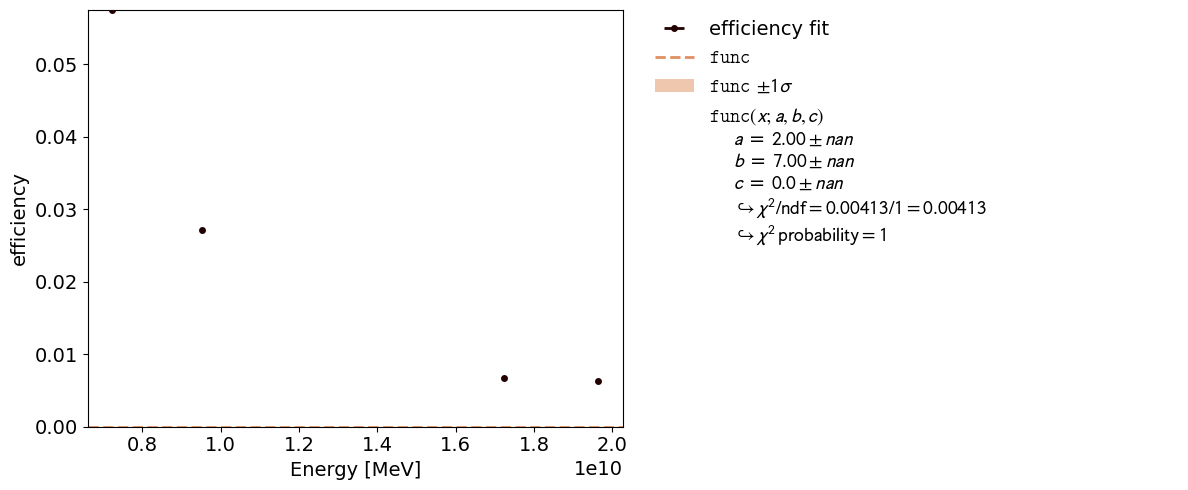

0.0194316360001191+/-nan

In [ ]:
pair_arr=np.array([[x[0],x[1]] for x in eff_pairs])
peaks_arr =np.array([x[2] for x in eff_pairs])
unc_array= np.array([[x[0],x[1]] for x in eff_uncertainty])
unc_array=np.delete(unc_array,2,axis=0)
pair_arr=np.delete(pair_arr,2,axis=0)
# plt.plot(pair_arr[:,0],pair_arr[:,1],"x")
# plt.title("detector efficiency at different energies")
# plt.xlabel("Energy [MeV]")
# plt.ylabel("efficiency")
# plt.grid(1)
# plt.show()
def func(x,a=2,b=7,c=0):
    return a*np.exp(-b*x)+c
data = kafe2.XYContainer(pair_arr[:,0], pair_arr[:,1])
data.label = 'efficiency fit'
print(unc_array[:,0])
data.add_error('x', unc_array[:,0])
data.add_error('y', unc_array[:,1])

fit_eff = kafe2.Fit(data,func)
fit_eff.do_fit()
pl = kafe2.Plot(fit_eff)
pl.y_label = 'efficiency'
pl.x_label = 'Energy [MeV]' 


pl.plot()
plt.show()

def efficiencyConversion(Energy,error=False):
    """
    returns the corresponding efficiency
    Args:
        float/ufloat: energy

    Returns:
        ufloat: efficiency
    """
    global fit_eff
    # if error:
    #     return (u.ufloat(fit_eff.parameter_values[0], fit_eff.parameter_errors[0])*channel+u.ufloat(fit.parameter_values[1], fit.parameter_errors[1]))*1e-6
    return u.ufloat(fit_eff.parameter_values[0],fit_eff.parameter_errors[0])*unp.exp(- u.ufloat(fit_eff.parameter_values[1],fit_eff.parameter_errors[1]) *Energy)+u.ufloat(fit_eff.parameter_values[2],fit_eff.parameter_errors[2])

efficiencyConversion(0.662)

['C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target85.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target70.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target55.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target40.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target25.dat']
['C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\target85.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\target70.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\target 55.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\target40.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\target25.dat']
done
done
done
done
done


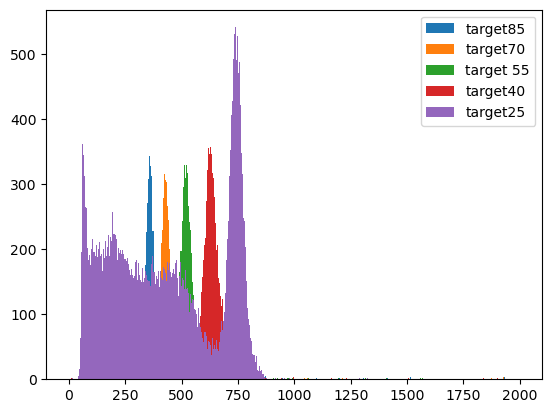

done
done
done
done
done


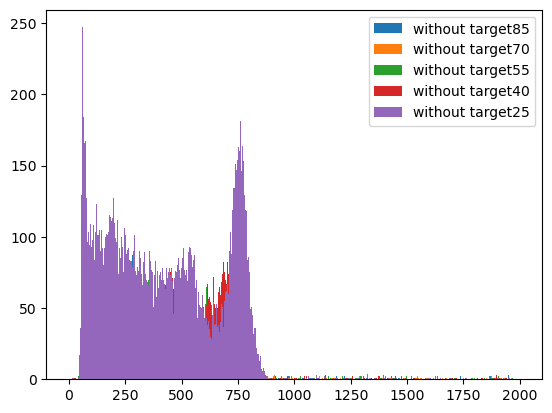

In [ ]:
background_files = [x for x in sorted(glob.glob(os.path.join(directory, '*.dat')), key=os.path.getmtime, reverse=True) if ("target" in x ) and ("without" in x)]


target_files = [x for x in sorted(glob.glob(os.path.join(directory, '*.dat')), key=os.path.getmtime, reverse=True) if ("target" in x)and not("without" in x)]
print(background_files)
print(target_files)

target_list = []
background_list = []

for file in target_files:
    file_name=file.split("\\")[-1].split(".")[-2]
    dxList1,tList1,nevent1= dat_extract(directory/file)
    
    n1, bins, patches1 = plt.hist(dxList1, nBins, range=(0,nBins*binSize), label=file_name)
    target_list.append([n1, bins, patches1 ])
plt.legend()

plt.show()

for file in background_files:
    file_name=file.split("\\")[-1].split(".")[-2]
    dxList1,tList1,nevent1= dat_extract(directory/file)
    
    n1, bins, patches1 = plt.hist(dxList1, nBins, range=(0,nBins*binSize), label=file_name)
    background_list.append([n1, bins, patches1 ])

plt.legend()
plt.show()



0.318+/-0.006 0.069+/-0.005
0.369+/-0.006 0.070+/-0.005
0.436+/-0.006 0.073+/-0.005
0.516+/-0.007 0.074+/-0.005
0.597+/-0.008 0.074+/-0.005


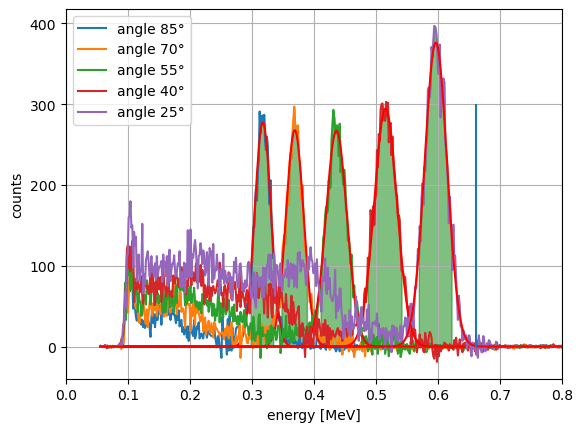

In [ ]:

energy_list=[]
energy2_list=[]

event_list=[]

labellist=[85,70,55,40,25]
fit_list=[[300, 400 ], [400, 500 ], [500, 700 ], [600, 700 ], [700, 800 ]]
for i in range(0,len(target_list)):
    
    plt.plot(convertChannel((target_list[i][1])[:-1]),  (target_list[i][0]-background_list[i][0]), label="angle "+str(labellist[i])+"°" )
    bin_centers,n1=(target_list[i][1])[:-1],  (target_list[i][0]-background_list[i][0])
    x,y,z=gauss_fit(bin_centers,n1, fit_list[i][0], fit_list[i][1], func=convertChannel,label=False)
    y=np.abs(y)
    energy=u.ufloat(convertChannel(x,True).n,convertChannel(y))
    energy2=u.ufloat(convertChannel(x,True).n,np.sqrt(convertChannel(x)))

    energy_list.append(energy)
    energy2_list.append(energy2)

    print(convertChannel(x,True),convertChannel(y,True))
    peak=integrate(bin_centers,n1,x,y,z,func=convertChannel,label=False)
    event_list.append(peak)
plt.grid(1)
plt.legend()
plt.xlim(0,0.8)
plt.xlabel("energy [MeV]")
plt.vlines(0.662,0,300,label="energy at 0°")
plt.ylabel("counts")

plt.show()




$\frac{d\phi}{d\Omega}=\frac{R(\Delta \Omega)}{\Delta \Omega}\cdot \frac{1}{\phi_0 n}\frac{1}{\epsilon}$

$n= \frac{N_A}{A}Z \rho \pi \left ( \frac{d}{2} \right)^2 l$

$\frac{1}{E'} = \frac{1}{E}-\frac{1}{m_0 c^2}(1-cos(\theta))$


gamma flux is $\phi_{det}=A_\gamma\frac{1}{4 \pi l^2}$ with $A_\gamma=A_0 e^{-ln(2) \frac{t_{passed}}{t_{1/2}}}$

$R_\gamma=\phi_{det} \pi r^2$
$\epsilon = \frac{4N l^2}{t_{meas} A_0   r^2}e^{ln(2) \frac{t_{passed}}{t_{1/2}}}$ 
efficiency

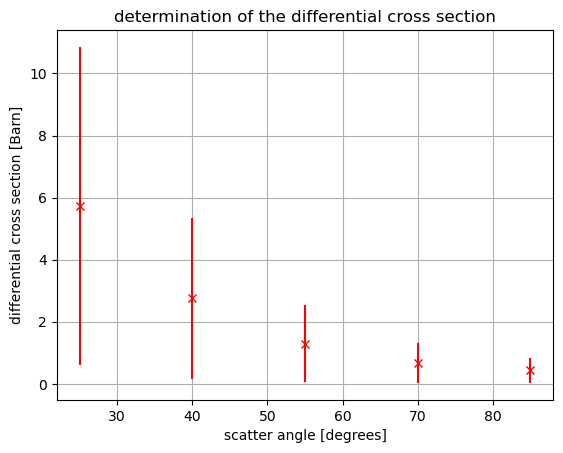

In [ ]:
electron_charge = 1.60217663e-19
rcp_energy_list=[1/(x*1e6*electron_charge) for x in energy_list]
rcp_energy2_list=[1/(x*1e6*electron_charge) for x in energy2_list]


def n(A, Z, rho, d, l):
    N_a = 1
    return N_a*Z*np.pi*rho*l*(d/2)**2/A

def diff_cross_section(R, DO, phi, n, epsilon):
    return R/(DO*phi*n*epsilon)

# plt.errorbar((1-np.cos(np.array(labellist)*np.pi/180 ))/np.pi*180 ,[x.n for x in rcp_energy2_list], [x.s for x in rcp_energy2_list], fmt="x")
# plt.errorbar((1-np.cos(np.array(labellist)*np.pi/180 ))/np.pi*180 ,[x.n for x in rcp_energy_list], [x.s for x in rcp_energy_list], fmt="x")

# plt.show()
energy_array=unp.uarray([x.n for x in energy_list],[x.s for x in energy_list])
Rate = unp.uarray(event_list,0)/(300)

del_om = np.pi*0.0252**2/0.208**2

t_hal=30

t_passed=2024.9-1971.5

A_0=u.ufloat(1.54e6,0.09e6)

n_el = 6.022e23*13/27*2.6989e3*np.pi*  0.0254*3/4

phi_0 = A_0*np.exp(-np.log(2)*t_passed/t_hal)/(4*np.pi*0.208**2) ## wrong divide by  4pi l^2



# plt.plot(labellist, diff_cross_section(Rate,del_om,phi_0,n_el, np.array([efficiencyConversion(x).n for x in energy_list]) )  ,"x")
dsigma=diff_cross_section(Rate,del_om,phi_0,n_el, efficiencyConversion(energy_array))*1e28
plt.errorbar(labellist, unp.nominal_values(dsigma),unp.std_devs(dsigma), fmt="x",color="r")
plt.grid(21)
plt.xlabel("scatter angle [degrees]")
plt.ylabel("differential cross section [Barn]")
plt.title("determination of the differential cross section")

plt.show()

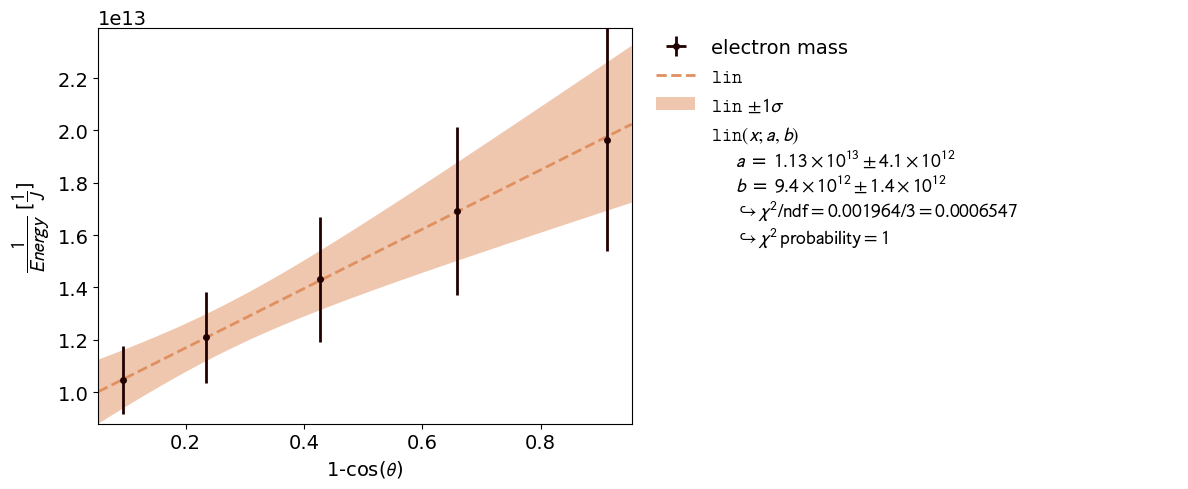

electron mass (9.8+/-3.5)e-31 initial gamma enregy (6.6+/-1.0)e+05


In [ ]:
def lin(x,a=1e13,b=1e13):
    return a*x+b


data = kafe2.XYContainer((1-np.cos(np.array(labellist)*np.pi/180 )),[x.n for x in rcp_energy_list])
data.label = 'electron mass'
data.add_error('y', [x.s for x in rcp_energy_list])

fit = kafe2.Fit(data,lin)

fit.do_fit()
pl = kafe2.Plot(fit)
pl.x_label = '1-cos($\\theta$)'
pl.y_label = '$\dfrac{1}{Energy}$ [$\dfrac{1}{J}$]' 

pl.plot()
plt.show()

a= u.ufloat(fit.parameter_values[0],fit.parameter_errors[0])
b= u.ufloat(fit.parameter_values[1],fit.parameter_errors[1])

c = 299792458 
print("electron mass", 1/(a*c**2),"initial gamma enregy",1/(b*electron_charge))

done
irion.dat
done
copper.dat
done
Al.dat
done
reference.dat


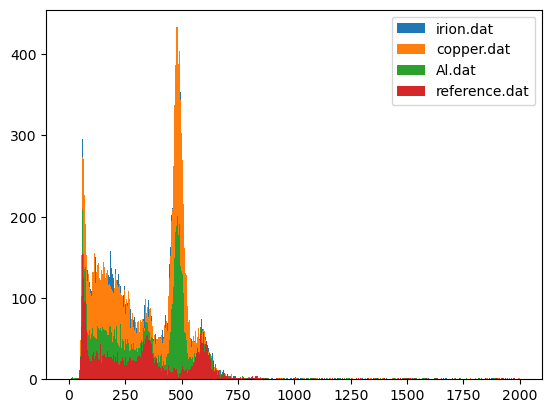

In [ ]:
material_files = ["irion.dat","copper.dat","Al.dat","reference.dat"]
directory
material_list = []
i=0

for file in material_files:
    dxList1,tList1,nevent1= dat_extract(directory/file)
    print(file)
    n1, bins, patches1 = plt.hist(dxList1, nBins, range=(0,nBins*binSize), label=material_files[i])
    material_list.append([n1, bins, patches1 ,material_files[i]])
    i=i+1
plt.legend()

plt.show()


3826.0
(5.5+/-2.0)e+09 (2.7+/-0.9)e+08


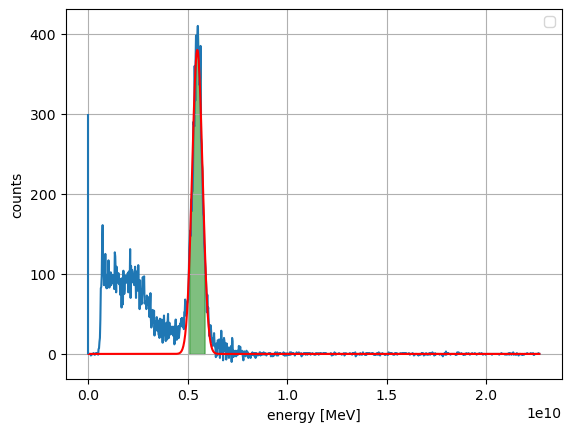

9435.0
(5.5+/-2.0)e+09 (2.7+/-0.9)e+08


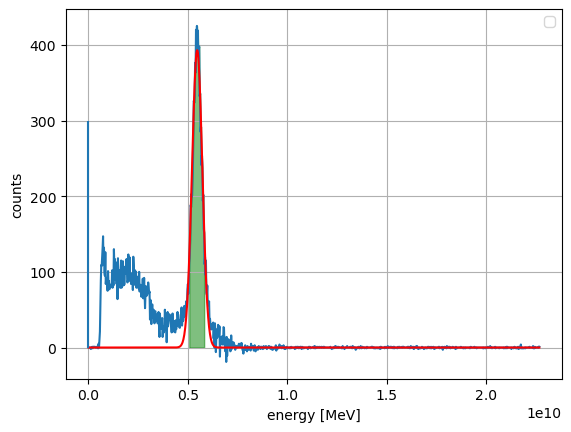

9577.0
(5.5+/-2.0)e+09 (2.4+/-0.8)e+08


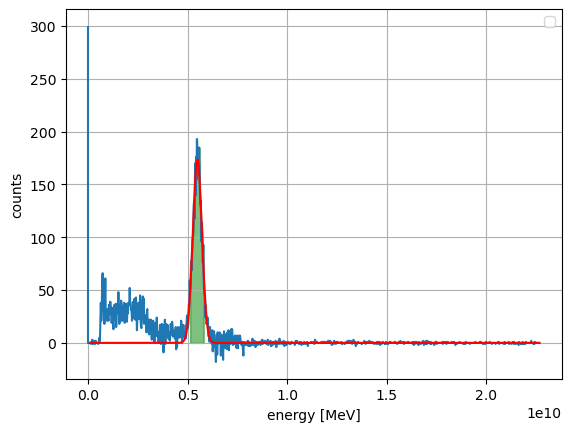

In [ ]:
# for i,material in enumerate(material_list[:-1]):
#     plt.plot(material[1][:-1],material[0]-material_list[-1][0])
#     plt.title(material_files[i])
#     plt.show()


event_material_list=[]

for i in range(0,len(material_list[:-1])):
    
    plt.plot(convertChannel((material_list[i][1])[:-1]), material_list[i][0]-material_list[-1][0])

    bin_centers,n1=(material_list[i][1])[:-1], material_list[i][0]-material_list[-1][0]
    x,y,z=gauss_fit(bin_centers,n1, 400,600, func=convertChannel,label=False)
    y=np.abs(y)
    
    material_energy=u.ufloat(convertChannel(x,True).n,convertChannel(y))

    print(peak)
    print(convertChannel(x,True),convertChannel(y,True))
    peak=integrate(bin_centers,n1,x,y,z,func=convertChannel,label=False)
    event_material_list.append([peak,material_list[i][3]])
    plt.grid(1)
    plt.legend()
    # plt.xlim(0,0.8)
    plt.xlabel("energy [MeV]")
    plt.vlines(0.662,0,300,label="energy at 0°")
    plt.ylabel("counts")

    plt.show()


[[9435.0, 'irion.dat'], [9577.0, 'copper.dat'], [3826.0, 'Al.dat']]


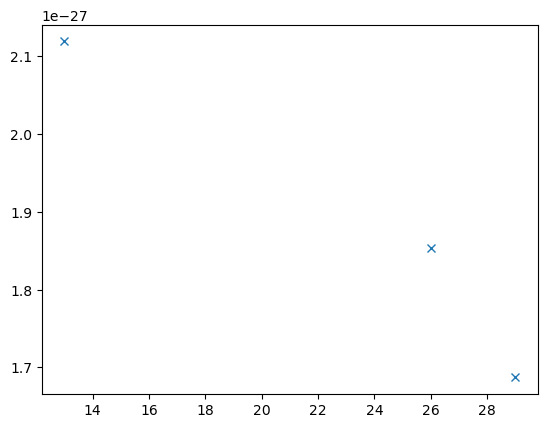

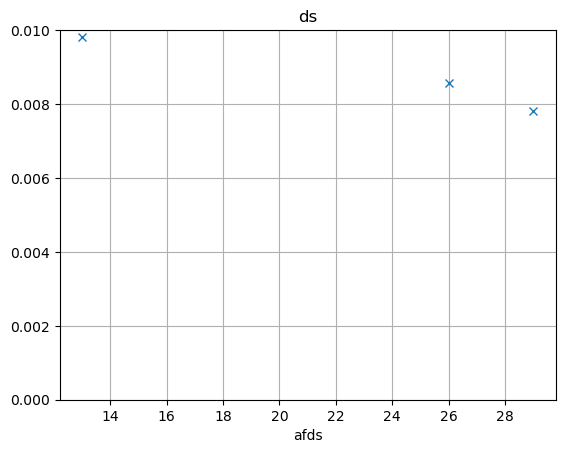

In [ ]:
print(event_material_list)
Rate = np.array([x[0] for x in event_material_list])/(300)
del_om = np.pi*0.0252**2/0.208**2

t_hal=30

t_passed=2024.9-1971.5

A_0=u.ufloat(1.54e6,0.09e6)
N_a=  	6.022e23
n_el = np.array([26,29,13])/np.array([55.845, 63.546,26.98])*N_a*np.array([7874, 8960, 2698.9])*np.pi*0.0254*3/4

phi_0 = A_0.n*np.exp(-np.log(2)*t_passed/t_hal) ## wrong divide by  4pi l^2


plt.plot([26,29,13], diff_cross_section(Rate,del_om,phi_0,n_el, efficiencyConversion(material_energy).n)  ,"x")

plt.show()


plt.plot([26,29,13], Rate*np.array([55.845, 63.546,26.98])/(np.array([7874, 8960, 2698.9])*np.array([26,29,13]) ) ,"x")
plt.xlabel("afds")
plt.ylabel("")
plt.title("ds")
plt.grid(True)
plt.ylim(0,0.01)
plt.show()
